In [266]:
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator


from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [236]:
df = pd.read_csv("iris.csv",)
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [237]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


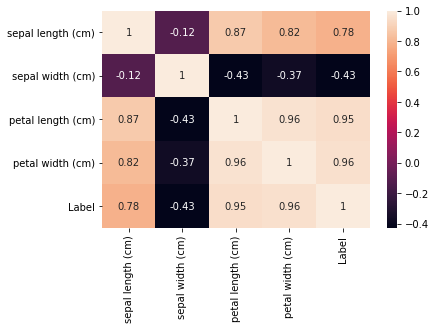

In [238]:
sb.heatmap(df.corr(),annot=True)

In [239]:
def get_flower_color(flower_label):
    if flower_label == 0:
        return "#fc0303"
    elif flower_label == 1:
        return "#03fc35"
    return "#0318fc"
colors = [get_flower_color(i) for i in df.Label]

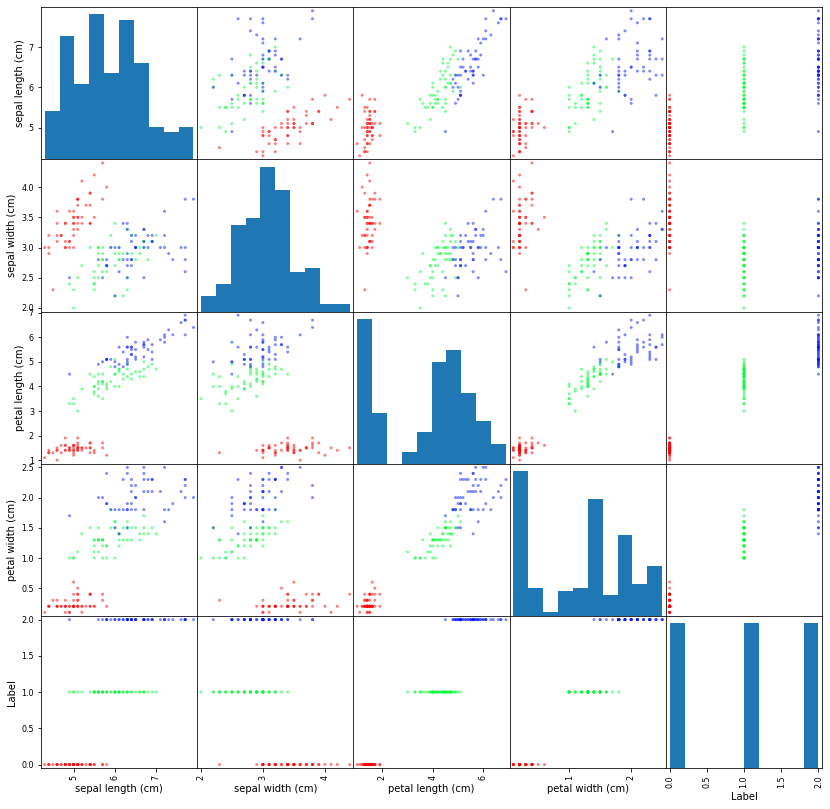

In [240]:
pd.plotting.scatter_matrix(df,color=colors,figsize=(14,14));

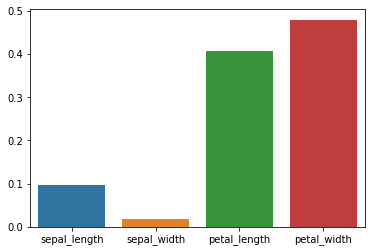

In [241]:

features = ['sepal_length', 'sepal_width', 'petal_length',
       'petal_width']
df.columns = features + ["Label"]
model = RandomForestClassifier()
X,y = df[features],df.Label
model.fit(X,y)
feature_importances = {i:j for i,j in zip(features,model.feature_importances_)}
sb.barplot(list(feature_importances.keys()),list(feature_importances.values()))

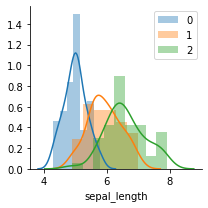

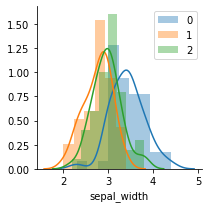

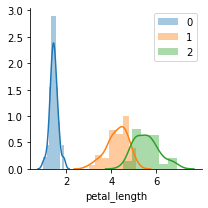

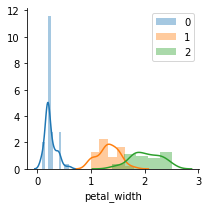

In [242]:
for feature in features:
    g = sb.FacetGrid(df, hue="Label")
    g = g.map(sb.distplot, feature)
    plt.legend()

In [243]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y)
X_train["Label"] = y_train
X_test["Label"] = y_test
X_train.to_csv("train.csv",index=False)
X_test.to_csv("test.csv",index=False)

train = pd.read_csv("train.csv")
X = train[features]
y = train.Label

/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/susmitvengurlekar/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [244]:
lof = LocalOutlierFactor()
good = lof.fit_predict(X) == 1
outlier_removed_X = X.loc[good,:]
outlier_removed_y = y[good]

In [245]:
print(f"Original Length: {len(X)}\nPrepped: {(len(outlier_removed_X),len(outlier_removed_y))}")

Original Length: 100
Prepped: (97, 97)


In [268]:
class FeatureGenerator(TransformerMixin,BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,*_):
        df["petal_width_sepal_width"] = df["petal_width"] * df["sepal_width"]
        df["petal_width_sepal_length"] = df["petal_width"] * df["sepal_length"]
        return df[["petal_width_sepal_width","petal_width_sepal_length"]]

    def get_feature_names(self):
        return ["petal_width_sepal_width","petal_width_sepal_length"]

ct = ColumnTransformer([
    ("feature_generator",FeatureGenerator(),["petal_width","sepal_length","sepal_width"]),
    ("dropper","drop",["sepal_width","sepal_length"]),
    ("passthrough","passthrough",["petal_width","petal_length"])
])

pipe = Pipeline([
    ("transformers",ct),
    ("poly",PolynomialFeatures(2)),
    ("scaler",MinMaxScaler())
])

svc_pipe = Pipeline([
    ("preprocessing",pipe),
    ("svc",SVC())
])

svc_pipe.fit(X,y)
#svc_pipe.fit(outlier_removed_X,outlier_removed_y) # cv 96

lr_pipe = Pipeline([
    ("preprocessing",pipe),
    ("lr",LogisticRegression())
])

lr_pipe.fit(X,y)
#lr_pipe.fit(outlier_removed_X,outlier_removed_y)  # cv 96

rf_pipe = Pipeline([
    ("preprocessing",pipe),
    ("rf",RandomForestClassifier())
])

rf_pipe.fit(X,y)
#rf_pipe.fit(outlier_removed_X,outlier_removed_y) # cv 94

Pipeline(memory=None,
         steps=[('preprocessing',
                 Pipeline(memory=None,
                          steps=[('transformers',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('feature_generator',
                                                                   FeatureGenerator(),
                                                                   ['petal_width',
                                                                    'sepal_length',
                                                                    'sepal_width']),
                                                                  ('dropper',
                                                               

In [269]:
svc_accuracies = cross_val_score(svc_pipe,X,y,cv=10);
lr_accuracies = cross_val_score(lr_pipe,X,y,cv=10);
rf_accuracies = cross_val_score(rf_pipe,X,y,cv=10);

In [270]:
for accuracies in [svc_accuracies,lr_accuracies,rf_accuracies]:
    print((accuracies.mean()*100,accuracies.std()*100))

(94.0, 9.165151389911678)
(94.0, 9.165151389911678)
(94.0, 9.165151389911678)


In [271]:
test = pd.read_csv("test.csv")
X = test[features]
y = test.Label

0.96


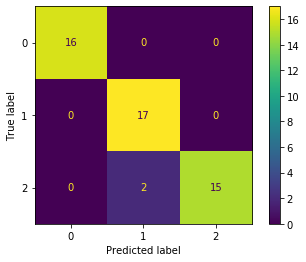

In [272]:
print(svc_pipe.score(X,y))
plot_confusion_matrix(svc_pipe,X,y);

0.96


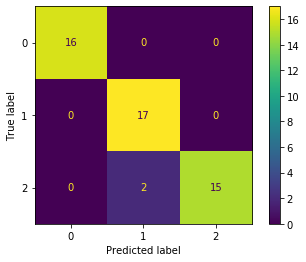

In [273]:
print(lr_pipe.score(X,y))
plot_confusion_matrix(lr_pipe,X,y);

1.0


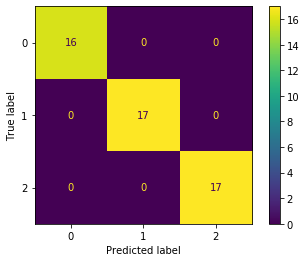

In [274]:
print(rf_pipe.score(X,y))
plot_confusion_matrix(rf_pipe,X,y);